In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import cvxpy as cvx

import puma560torch as pm
import scipy.integrate as itg
import torch as pt

%matplotlib inline

# Theory Question

Recall the robot dynamics from the previous homework. We use Lyapunov analysis to demonstrate how to reach to targets without canceling out all of the nonlinearities.

\begin{align*}
\dot \theta(t) &= \omega(t) \\
M(\theta(t)) \dot\omega(t) + C(\theta(t),\omega(t))\omega(t) + D\omega(t) + G(\theta(t)) &= u(t)
\end{align*}

* $\theta(t)$ are generalized coordinates. In our example, they are the angles of the joints of the robot. In this case there are six joints, so $\theta(t)\in\mathbb{R}^6$.
* $\omega(t)$ are the associated velocities of these coordinates. In this case, $\omega(t)\in\mathbb{R}^6$.
* $M(\theta)$ is called the mass matrix. It is symmetric and positive definite. In this case, it is $6\times 6$.
* $C(\theta,\omega)$ is called the coriolis matrix. It is also $6\times 6$.
* $D$ is a positive definite damping matrix. It is constant for simplicity.
* $G(\theta)$ captures of the effects of gravity. 
* $G(\theta) = \nabla_\theta U(\theta)$ where $U(\theta)$ is the potential energy.
* $u(t)$ are the torques that are input into the joints by the motors.

Let $f:\mathbb{R}^6\to \mathbb{R}^3$ be the mapping encoding the transformation from joint angles to the tool position. (Note that we are ignoring the tool orientation.)

Let $\hat U(\theta) = \frac{K}{2}\|f(\theta)-p_{des}\|^2$, where $p_{des}$ is the desired location and $K$ is a positive number. Say that
$$
u(t) = G(\theta(t)) - \nabla_{\theta} \hat U(\theta(t)).
$$

Use Lyapunov analysis to show that if $f(\bar{\theta})=p_{des}$ and $\bar\omega=0$, then $(\bar\theta,\bar\omega)$ define a stable equilibrium of the resulting system.


# Coding Demonstration

Now we will see how to reach individual points. Later you will modify this to reach to a desired trajectories. Note, I have updated the code so that it uses `pytorch` instead of standard `numpy` and `scipy`. Coding in `pytorch` is very similar to using `numpy` and `scipy`. It has the major advantage that most numerical functions coded in `pytorch` are differentiable. (We will demonstrate how to take derivatives below.)

Additionally, (and surprisingly) it runs faster, too. The only downside is that to utilize various `scipy` and commands, you need to convert between `pytorch` tensors and `numpy` arrays. (The overhead for this is small.)



You can install `pytorch` in a terminal using
```
pip3 install torch
```


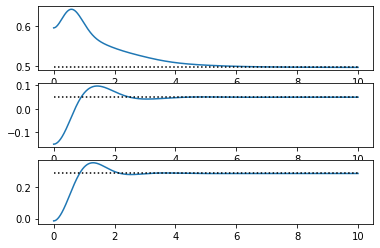

In [2]:

robot = pm.PUMA()

theta_neutral = np.pi * pt.tensor([0,.25,1.,0,.25,0])
M = robot.fkine(theta_neutral)
p = M[:3,-1]
R = M[:3,:3]
px,py,pz = p

p_des = p + pt.tensor([-.1,.2,.3])

M_des = pm.toSE3(R,p_des)
Thetas = robot.ikine(M)

def pointController(x):
    # K acts as a gain
    K = 50.
    
    q = x[:6].clone().detach().requires_grad_(True)
    
    # The line above copies the angles
    # to a new variable 
    # The requires_grad_(True) part ensures that
    # functions of q can be differentiated.
    
    G = robot.grav_torque(q)
    M = robot.fkine(q)
    p = M[:3,-1]
    
    posCost = .5 * K * pt.sum((p-p_des)**2)
    
    # Here is how we take the gradient
    posCost.backward()
    # The gradient with respect q is now here
    grad = q.grad
    
    return G - grad
    


# Basic Closed-Loop System
def closedLoopVF(x,t):
    # First convert from numpy array to pytorch tensor
    x_pt = pt.tensor(x)
    u = pointController(x_pt)
    x_dot = robot.vectorField(x_pt,u)
    # Convert back to a numpy array
    x_dot_np = x_dot.detach().numpy()
    return x_dot_np

# Now run a simulation
Time = np.linspace(0,10,1000)
x0 = np.hstack([theta_neutral.detach().numpy(),np.zeros(6)])
X = itg.odeint(closedLoopVF,x0,Time)

# On my computer the simulation takes about 12 seconds.

# To use it with the robot
# we must convert back to a torch tensor
X = pt.tensor(X)
Positions = []
for x in X:
    M = robot.fkine(x[:6])
    Positions.append(M[:3,-1])
    
Positions = pt.stack(Positions)

fig,ax = plt.subplots(3,1)
for i in range(3):
    ax[i].plot(Time,Positions[:,i])
    ax[i].plot([Time[0],Time[-1]],[p_des[i],p_des[i]],'k:')

# Coding Question

Modify the code so that it tracks the desired positions plotted above. (The desired  positions were coded as a function so that you could use them with `odeint` if desired.) 

Plot the the obtained positions and the desired positions on the same plots so to assess the performance. The tracking performance will probably not be as good as what we saw last week with feedback linearization.

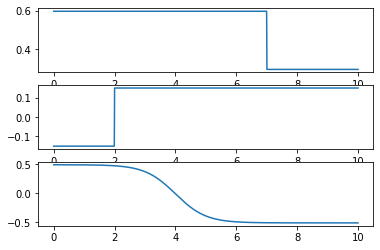

In [3]:
theta_neutral = np.pi * pt.tensor([0,.25,1.,0,.25,0])
M_neutral = robot.fkine(theta_neutral)

def desiredPositions(t):
    p = M_neutral[:3,-1]
    px,py,pz = p
    if t > 2:
        y_jump = .3
    else:
        y_jump =0.
        
    if t > 7:
        x_jump = -.3
    else:
        x_jump = 0.
    
    p_des = pt.stack([px+x_jump,
                      py+y_jump,
                      pz + .5 * pt.tanh(4-t)])
    return p_des
    
P_traj = pt.stack([desiredPositions(t) for t in pt.tensor(Time)])

fig,ax = plt.subplots(3,1)

for i in range(3):
    ax[i].plot(Time,P_traj[:,i])
    

In [ ]:
# Put your code here



# Coding Background

Here we will demonstrate a simple method for coding up model predictive control using `cvxpy`. This is just so that you have an example of how the process works.

If you have not installed `cvxpy` you can an install it in a terminal via the command

```
pip3 install cvxpy
```

The optimization problem solved at each stage will be given by $\mathbb{P}_N(x)$:
\begin{align*}
& \min && {\bf x}_N^\top Q{\bf x}_N \\
& \textrm{subject to} && {\bf x}_0 = x\\
&&&
{\bf x}_{i+1} = A{\bf x}_i + B{\bf u}_i \textrm{ for } i=0,\ldots,N-1\\
&&& -1\le {\bf u}_i \le 1 \textrm{ for } i=0,\ldots,N-1
\end{align*}

Note that this problem does not satisfy the conditions for stability that we will discuss in class. But we will see that stability seems to hold provided that $N\ge 2$. Here $A$ and $B$ will encode Newton's equations in discrete time, and $Q$ is a positive definite matrix.

Text(0.5, 0, 'Time')

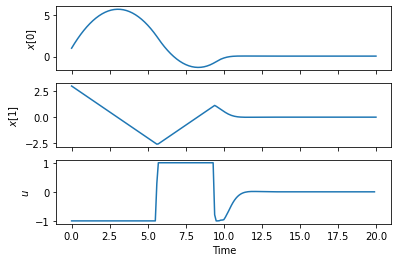

In [4]:
# First define the matrices.
h = 0.1
m = 1.

A = np.array([[1.,h],
              [0,1.]])
B = np.array([[0.],
              [h/m]])

Q = np.diag([10,1.])
# Matrix square root
Qrt = la.cholesky(Q)
# Now define the problem via cvxpy symbolics
N = 10 # MPC Horizon
n,p = B.shape
x0 = cvx.Parameter(n)
U_var = cvx.Variable((N,p))
Constraints = []
for i in range(N):
    if i == 0:
        x = x0
    
    u = U_var[i]
    Constraints.extend([u<=1,-1<=u])
    x = A@x+B@u
    
cost = cvx.sum_squares(Qrt@x)
prob = cvx.Problem(cvx.Minimize(cost),Constraints)

# Now define the MPC controller

def mpcControl(x):
    # Set the parameter value
    x0.value = x
    # Solve the problem
    prob.solve()
    if prob.status == 'optimal':
        # If the optimization worked
        # Return the first input
        return U_var.value[0]
    else:
        # It didn't work so don't return anything
        return None

# Now run a simulation with the the controller

x = np.array([1.,
              3.])

X = [x]
U = []
NumSteps = 200
for step in range(NumSteps):
    u = mpcControl(x)
    if u is None:
        print('MPC Failed')
        break
        
    U.append(u)
    
    x = A@x+B@u
    
    X.append(x)
    
X = np.array(X)
U = np.array(U)

Time = h * np.arange(len(X))

fig,ax = plt.subplots(3,1,sharex=True)
ax[0].plot(Time,X[:,0])
ax[0].set_ylabel(r'$x[0]$')
ax[1].plot(Time,X[:,1])
ax[1].set_ylabel(r'$x[1]$')
ax[2].plot(Time[:-1],U)
ax[2].set_ylabel(r'$u$')
ax[2].set_xlabel('Time')


Note how the algorithm ensures that $|u(t)|\le 1$.

There are several ways to encode the cost function in `cvxpy`. They will all get the same answer, but some are slower for MPC. In particular, you could use
```
cost = cvx.quad_form(x,Q)
```
but this gives slower performance in some settings.


# Background: Stability of Discrete-Time Linear Systems

A discrete-time linear system with no inputs takes the form:

$$
x_{t+1} = Ax_t.
$$

Iterating this equation shows that $x_t = A^t x_0$. The main theorem for linear system stability is that the following statements are equivalent:

* The discrete-time linear system is asymptotically stable.
* All eigenvalues of $A$ have magnitudes strictly less than $1$.
* For any positive definite $Q$ there is a positive definite $P$ such that
$$
P = Q + A^\top P A 
$$

The final equation is called the discrete-time linear Lyapunov equation. It gets this name because any $P$ that satisfies the Lyapunov equation for a positive definite $Q$ defines a Lyapunov function by $V(x) = x^\top P x$. 

The system 
$$
x_{t+1} = Ax_t + B u_t
$$
is called *stabilizable* if there is a gain $H$ such that setting $u_t=Hx_t$ makes the closed-loop system given by 
$$
x_{t+1} = (A+BH)x_t
$$
asymptotically stable.

# Theory Question

Show that if $P$ satisfies the linear Lyapunov equation, then

$$
x_0^\top P x_0 = \sum_{t=0}^{\infty} x_t^\top Q x_t.
$$

Either write your solution here or attach a hand-written file.

# Theory Question

Let  $P$ be a solution to the Lyapunov equation for a positive definite $Q$.
Show that $V(x) = x^\top Px$ satisfies the formal definition for a Lyapunov equation in Definition 2.12 of the MPC text.

Hint: For any vector $x$, you can use the fact that $\lambda_{\min}(P) x^\top x \le x^\top P x \le \lambda_{\max}(P) x^\top x$, where $\lambda_{\min}(P)$ and $\lambda_{\max}(P)$ are the minimum and maximum eigenvalues of $P$, respectively. 

Either write your solution here or attach a hand-written file.

# Background: Discrete-Time Linear Quadratic Regulators

The discrete-time version of the linear quadratic regulator (LQR) problem is similar to the continuous-time version. As with the continuous-time case, we can pose finite and infinite horizon versions. We will focus on the infinite horizon version.

\begin{align*}
& \min && \sum_{t=0}^\infty (x_t^\top Q x_t + u_t^\top R u_t) \\
& \textrm{subject to} && x_{t+1} = Ax_t +Bu_t
\end{align*}

When $Q$ and $R$ are positive definite and the system is stabilizable, then the infinite horizon LQR problem has a solution given by 
\begin{align*}
u_t &= Kx_t \\
K &= -(R+B^\top S B)^{-1} B^\top SA \\
S &= Q + A^\top S A - A^\top S B(R+B^\top SB)^{-1} B^\top SA
\end{align*}

The last equation is called the discrete-time algebraic Riccati equation. `scipy.linalg` has a command for computing this called `la.solve_discrete_are`.

# Theory Question

Show that if $S$ is positive definite and $S$ is a solution to the discrete-time algebraic Riccati equation, then $S$ is a Lyapunov function for the closed-loop system:
$$
x_{t+1} = (A+BK)x_t
$$

Either write your solution here or attach a hand-written file.

# Theory Question

Let $S$ be the Riccati solution and let $K$ be the corresponding gain from before. Let $c>0$ be positive. Let

* $V_f(x) = x^\top Sx$

* $\mathbb{X}_f = \{x | V_f(x)\le c\}$


Show that the following properties hold:

* $\min_u \left[x^\top Q x +u^\top R u + V_f(Ax+Bu)\right] \le V_f(x)$ 
* In particular, show that if $x\in\mathbb{X}_f$ and $u=Kx$, then $Ax+Bu \in \mathbb{X}_f$.


# Coding Question

Consider $A$, $B$, $Q$, and $R$ as below:

In [ ]:
h = 0.1
m = 1.

A = np.array([[1.,h],
              [0,1.]])
B = np.array([[0.],
              [h/m]])

Q = np.eye(2)
R = np.eye(1)

Find the Riccati solution, and find the largest value of $c$ such that the following constraints hold:
\begin{equation*}
-2 \le \begin{bmatrix}1 & 0 \end{bmatrix}x \le 2 \\
-1 \le Kx \le 1
\end{equation*}
for all $x$ such that $x^\top S x \le c$. 

Plot the ellipsoid given by $\{x|x^\top S x \le c\}$ along with the boundaries of the constraints. (If you have maximized the $c$, the boundary of the ellipsoid should touch at least one of the constraint boundaries.)

Print the value of $c$ so that I can check it.

(The lecture describing energy functions gave an example of doing surface plots. Plus there are lots of examples  online.)

(You can either find $c$ analytically or use a software package such as `cvxpy` to compute it.)

In [ ]:
# Put your code here

# Coding Question

Implement MPC for the system from the previous problem with $\mathbb{P}_N(x)$ given by
\begin{align*}
& \min && \sum_{i=0}^{N-1}({\bf x}_i^\top Q {\bf x_i} + {\bf u}_i^\top  R {\bf u}_i) + 
{\bf x}_N^\top S {\bf x}_N \\
& \textrm{subject to} && {\bf x}_0 = x \\
&&& {\bf x}_{i+1} = A {\bf x}_i + B {\bf u}_i \textrm{ for } i=0,\ldots,N-1\\
&&& -2 \le \begin{bmatrix} 1 & 0 \end{bmatrix} {\bf x}_i \le 2 \textrm{ for } i=0,\ldots,N-1 \\
&&& -1 \le {\bf u}_i \le 1 \textrm{ for } i=0,\ldots,N-1 \\
&&& {\bf x}_N^\top S {\bf x}_N \le c
\end{align*}

Simulate your controller for $50$ time steps for MPC horizons of $N=10,20,30$. In each setting, use an initial condition of
\begin{equation*}
x(0) = \begin{bmatrix}1\\0\end{bmatrix}.
\end{equation*}
Plot the state and input trajectories as functions of time.

Explain what happens if you used $N=5$.

In [ ]:
# Put your code here